# 1. Binary Classification

## Logistic Loss Objective Value

Objective Function:
$ q (w; x, y) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big)$ 

l2 regularizer addition:
$\frac{\lambda}{2} \| w \|_2^2 $.

l1 regularizer addition: 
$\lambda| w \|^1 $

In [1]:
import numpy

# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def logistic_loss(y,x,w,l1=False,l2=False,lam=0):
    exponent = float(numpy.exp(-y * numpy.dot(x,w))) # scalar
    objective = numpy.log(1 + exponent) 
    if l2:
        objective += lam/2 * numpy.sum(numpy.multiply(w,w))
    if l1:
        objective += numpy.sum(numpy.abs(w)) 
    return objective

In [28]:
# gradient of logisitic loss
# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def logistic_gradient(y,x,w,l1=False,l2=False, lam=0):
    d, _ = w.shape
    exponent = float(numpy.exp(y * numpy.dot(x,w))) # scalar
    derivative = (-y * x) / (1 + exponent) 
    derivative = derivative.reshape((d,1))# d by 1
    if l2:
        derivative += lam * w
    if l1:
        derivative += numpy.multiply(numpy.sign(w),w)
    return derivative

# 2. Regression

## Linear Regression

Objective Function:
$ q (w; x, y) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big)$ 

l2 regularizer addition:
$\frac{\lambda}{2} \| w \|_2^2 $.

l1 regularizer addition: 
$\lambda| w \|^1 $

In [38]:
# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def linear_loss(y,x,w,l1=False,l2=False,lam=0):
    loss = numpy.dot(x,w) - y
    loss = numpy.sum(numpy.multiply(loss,loss))
    if l2:
        loss += lam * numpy.sum(numpy.multiply(w,w))
    if l1:
        loss += lam * numpy.sum(numpy.abs(w))
    return loss

In [36]:
# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def linear_gradient(y,x,w,l1=False,l2=False,lam=0):
    d, _ = w.shape
    scalar = numpy.dot(x,w) - y
    vector = scalar * x 
    vector = vector.reshape((d,1))
    if l2:
        vector += lam * w
    if l1:
        vector += numpy.multiply(numpy.sign(w),w)
    return vector

## 3. SAGA Algorithm

In [5]:
# X: training set, n by d 
# y: training labels, n by 1 
# step_size, can't go wrong with 1/3L
# lam: scalar
# max_epochs = scalar
# proximal: not always used default should be lambda x
# obj_func: R^d -> R^1
# grad_func: R^d -> R^d
# l1 and l2 = Booleans
def saga(X,y,step_size,max_epochs,proximal,obj_func,grad_func,l1=False,l2=False,lam=0):
    # average obj values per epoch
    obj_vals = []
    n, d = X.shape  
    w = numpy.zeros((d,1)) # d by 1 weight vector
    # initialize table with derivative w/weight 0
    derivatives = numpy.zeros((n,d))
    for i in range(n):
        derivatives[i,:] = grad_func(y[i],X[i,:],w,l1,l2,lam).reshape(d)
        
    for epoch in range(max_epochs):
        # shuffle data points for an epoch
        permutation = numpy.random.permutation(n)
        X_shuffled = X[permutation,:]
        y_shuffled = y[permutation,:]
        obj_epoch = 0
        for i in range(n):
            # target data point and label
            xi = X_shuffled[i,:]
            yi = y_shuffled[i]

            updated_deriv = grad_func(yi,xi,w,l1=l1,l2=l2,lam=lam) # d by 1
            previous_deriv = derivatives[permutation[i],:].reshape((d,1)) # d by 1
            derivatives[permutation[i],:] = updated_deriv.reshape(d)
            table_avg = numpy.mean(derivatives,axis=0).reshape((d,1))
            update = updated_deriv - previous_deriv + table_avg
            w = w - (step_size * update)
            # apply proximal operator
            w = proximal(w)
            obj_iter = obj_func(y_shuffled[i],X_shuffled[i,:],w,l1=l1,l2=l2,lam=lam)
            obj_epoch += obj_iter

        obj_epoch /= n
        obj_vals.append(obj_epoch)
        print('Objective value at epoch '+ str(epoch) + ' is '+ str(obj_epoch))
    return w, obj_vals

# 4. Import Datasets

## *** Sanity Check

In [42]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))


# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))


# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))


n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x: (768, 8)
Shape of y: (768,)
Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)
test mean = 
[[ 0.10421113  0.06910884 -0.18554799  0.12258025  0.21013553 -0.19029435
  -0.07554382 -0.1076603 ]]
test std = 
[[1.08966105 0.89390061 1.3325008  0.90801007 1.23448541 1.13490246
  0.95649294 0.90967362]]
Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [43]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(X_train,X_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
w, obj_vals = saga(x_train,y_train,step_size,100,proximal,logistic_loss,logistic_gradient,l2=True,lam=alpha)

Objective value at epoch 0 is 0.5271832747101184
Objective value at epoch 1 is 0.48420746073632526
Objective value at epoch 2 is 0.47584621897387835
Objective value at epoch 3 is 0.4729779538911396
Objective value at epoch 4 is 0.47177987867784266
Objective value at epoch 5 is 0.47200486866098335
Objective value at epoch 6 is 0.47179074366958834
Objective value at epoch 7 is 0.4717422561982728
Objective value at epoch 8 is 0.47180327803652916
Objective value at epoch 9 is 0.4718146894650788
Objective value at epoch 10 is 0.4718086867915473
Objective value at epoch 11 is 0.47181542444270413
Objective value at epoch 12 is 0.47181802673432627
Objective value at epoch 13 is 0.47181491942305576
Objective value at epoch 14 is 0.4718138845854788
Objective value at epoch 15 is 0.4718160959490511
Objective value at epoch 16 is 0.47181543884784316
Objective value at epoch 17 is 0.4718152210807105
Objective value at epoch 18 is 0.4718152947844213
Objective value at epoch 19 is 0.47181527144842716

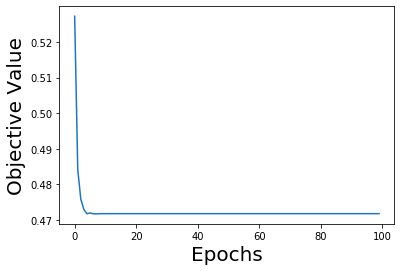

In [44]:
import matplotlib.pyplot as plt

epochs_gd = range(len(obj_vals))
plt.plot(epochs_gd, obj_vals)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.show()

## 4.1 Mnist 

Data from http://yann.lecun.com/exdb/mnist/

### 4.1.1 Read files

In [29]:
#https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        array = numpy.frombuffer(f.read(), dtype=numpy.uint8).reshape(shape)
        return array.copy()

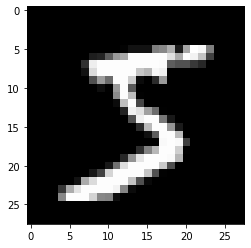

The testing label is 5


In [30]:
import matplotlib.pyplot as plt 

X_test = read_idx("mnist/t10k-images-idx3-ubyte")
y_test = read_idx("mnist/t10k-labels-idx1-ubyte")

X_train = read_idx("mnist/train-images-idx3-ubyte")
y_train = read_idx("mnist/train-labels-idx1-ubyte")


plt.imshow(X_train[0,:,:],cmap='gray')
plt.show()
print('The testing label is ' + str(y_train[0]))

### 4.1.2 Process Labels 

As explained in http://proceedings.mlr.press/v32/defazio14.pdf the digits 0-4 are class 1 and 5-9 class 2

In [31]:
y_train = numpy.array(list(map(lambda x:-1 if x < 5 else 1,y_train)))
y_test = numpy.array(list(map(lambda x:-1 if x <5 else 1, y_test)))

### 4.1.3 Process Images

Vectorize 28x28 images to 1 by 768 and normalize them

In [32]:
X_train = X_train[:1000,:,:]
y_train = y_train[:1000]
train_n,d,_ = X_train.shape
test_n,_,_ = X_test.shape

X_train = X_train.reshape((train_n,d*d))
X_test = X_test.reshape((test_n,d*d))


y_train = y_train.reshape((train_n,1))
y_test = y_test.reshape((test_n,1))

# create new matrix with normalized rows
def normalize(matrix):
    ret = numpy.zeros(matrix.shape)
    for i in range(len(matrix)):
        vector = matrix[i]
        divisor = numpy.linalg.norm(vector)
        ret[i] = vector / divisor
    return ret

X_train = normalize(X_train)
X_test = normalize(X_test)

In [33]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(X_train,X_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
w, obj_vals = saga(X_train,y_train,step_size,100,proximal,logistic_loss,logistic_gradient,l2=True,lam=alpha)

Objective value at epoch 0 is 0.6796231167945326
Objective value at epoch 1 is 0.6539823248154246
Objective value at epoch 2 is 0.6331316702834037
Objective value at epoch 3 is 0.6149593078201263
Objective value at epoch 4 is 0.5990876880779271
Objective value at epoch 5 is 0.5851565057175113
Objective value at epoch 6 is 0.573241920300928
Objective value at epoch 7 is 0.5624369942420764
Objective value at epoch 8 is 0.5530450430814641
Objective value at epoch 9 is 0.5442768588527147
Objective value at epoch 10 is 0.5362941244051875
Objective value at epoch 11 is 0.5290433741175097
Objective value at epoch 12 is 0.5223260747159906
Objective value at epoch 13 is 0.5161119531062306
Objective value at epoch 14 is 0.5105066886551374
Objective value at epoch 15 is 0.5050645205029903
Objective value at epoch 16 is 0.5000067907793382
Objective value at epoch 17 is 0.49518037828468714
Objective value at epoch 18 is 0.4908211119483429
Objective value at epoch 19 is 0.48647422074256014
Objective

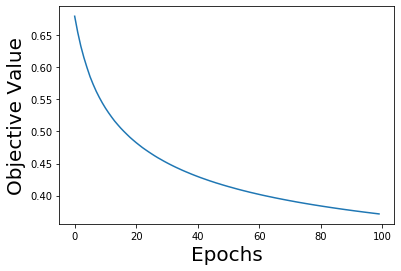

In [11]:
import matplotlib.pyplot as plt

epochs_gd = range(len(obj_vals))
plt.plot(epochs_gd, obj_vals)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.show()

## 4.2 Million Song from UCI

Regression from https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd

In [6]:
from sklearn import datasets
import numpy

raw_data = open('YearPredictionMSD', 'rt')
data = numpy.loadtxt(raw_data, delimiter=",")
print(data.shape)

(515345, 91)


In [7]:
def standardize(x_train,x_test):
    # calculate mu and sig using the training set
    d = x_train.shape[1]
    mu = numpy.mean(x_train, axis=0).reshape(1, d)
    sig = numpy.std(x_train, axis=0).reshape(1, d)

    # transform the training features
    x_train = (x_train - mu) / (sig + 1E-6)

    # transform the test features
    x_test = (x_test - mu) / (sig + 1E-6)

In [8]:
labels = data[:,0]
all_data = data[:,1:]

n,d = all_data.shape

all_data = numpy.concatenate((all_data, numpy.ones((n, 1))), axis=1)

labels = labels.reshape((n,1))
all_data = all_data.reshape((n,d+1))


print(labels.shape)
print(all_data.shape)

X_train = all_data[:100,:]
y_train = all_data[:100]
X_test = all_data[100:,:]
y_test = all_data[100:]
print(X_train.shape)
print(y_train.shape)

standardize(X_train,X_test)

(515345, 1)
(515345, 91)
(100, 91)
(100, 91)


In [39]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(X_train,X_train.T))
L = eigs[0]
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (2 * n * alpha + L)
w, obj_vals = saga(X_train,y_train,step_size,100,proximal,linear_loss,linear_gradient,l2=True, l1=False,lam=alpha)

Objective value at epoch 0 is 0.9730502100401389
Objective value at epoch 1 is 0.9220058374598464
Objective value at epoch 2 is 0.879612697504288
Objective value at epoch 3 is 0.8436382222465588
Objective value at epoch 4 is 0.8130972855032906
Objective value at epoch 5 is 0.7857621887067442
Objective value at epoch 6 is 0.7623124447686848
Objective value at epoch 7 is 0.7420221416834104
Objective value at epoch 8 is 0.7233817561592767
Objective value at epoch 9 is 0.7073646281566887
Objective value at epoch 10 is 0.6929632042329144
Objective value at epoch 11 is 0.6797086430570667
Objective value at epoch 12 is 0.6675667183291315
Objective value at epoch 13 is 0.6566075288552039
Objective value at epoch 14 is 0.6464979344712074
Objective value at epoch 15 is 0.6373574258917102
Objective value at epoch 16 is 0.6286625352632034
Objective value at epoch 17 is 0.6207424615878345
Objective value at epoch 18 is 0.6131859022635844
Objective value at epoch 19 is 0.6063036359935668
Objective v

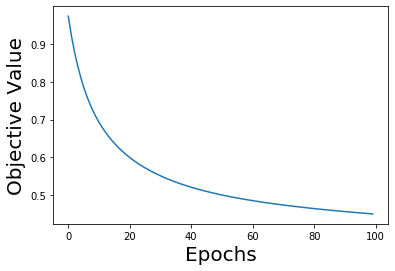

In [40]:
import matplotlib.pyplot as plt

epochs_gd = range(len(obj_vals))
plt.plot(epochs_gd, obj_vals)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.show()

### 4.3 CovType